# 주식 테마별 코로나 영향 분석
- 태마별로 다른 산업군들이 분류되어있어 코로나에 따른 가격변동 역시 다르게 일어났을거라 추정
- 데이터 수집 후 시각화하여 분석

1. 네이버 파이낸스에서 태마별 주식 카테고리와 코드 스크래핑
    - 테마코드 스크래핑
        - https://finance.naver.com/sise/theme.nhn
    - 테마별 종목코드 스크래핑
        - https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=493
    - FinanceDataReader로 종목이름의 코드 로드
        - http://www.gisdeveloper.co.kr/?p=8413
2. 일자별 테마별 평균 종가를 테이블로 정리
    - 주식들의 가격폭을 맞추기위해 평균계산 전 노말라이즈
3. 테마별로 기간동안 어떻게 등락하였는지 추이 비교
    - line 플롯으로 시각화 후 분석

## 주식 테마별 코드 수집
- 네이버 파이낸스 테마별 시세 페이지에서 각 테마의 코드를 스크래핑
- 각 테마의 페이지에서 주식종목 리스트를 수집하기 위함
- https://finance.naver.com/sise/theme.nhn?&page=1

In [403]:
# library import 다른 것들은 startup파일 통해 실행
import requests
from bs4 import BeautifulSoup as bs

In [404]:
#크롤링할 총 페이지의 카운트, 종목수가 많아 첫 페이지만 실행
page_count = 1
# 빈 리스트 생성
links = []

# 페이지를 반복문으로 돌며 스크래핑
for i in range(1,page_count+1):
    page = i
    url = f'https://finance.naver.com/sise/theme.nhn?&page={page}'
    result = requests.get(url)
    soup = bs(result.text,'lxml')
    # 테이블 > 테이블데이터(class = col_type1) > a태그 셀렉트
    temp = soup.select('table td.col_type1 a')
    # 빈 리스와 합치기
    links = links + temp
    print(len(links))
    

40


In [405]:
# links 미리보기
links[:3]

[<a href="/sise/sise_group_detail.nhn?type=theme&amp;no=493">mRNA(메신저 리보핵산)</a>,
 <a href="/sise/sise_group_detail.nhn?type=theme&amp;no=458">K-뉴딜지수(바이오)</a>,
 <a href="/sise/sise_group_detail.nhn?type=theme&amp;no=197">폐기물처리</a>]

In [156]:
# 빈 딕셔너리 생성
theme_dict = {}

# 'no='뒤에있는 테마코드(키)와 테마이름으로(벨류) 딕셔너리 생성
for link in links:
    theme_dict[link['href'][42:]] = link.string

In [157]:
theme_dict.keys(), theme_dict.values()

(dict_keys(['493', '460', '322', '294', '319', '197', '427', '390', '443', '232', '376', '389', '448', '473', '229', '209', '408', '108', '458', '464', '467', '124', '456', '447', '436', '174', '397', '42', '265', '242', '63', '399', '56', '437', '121', '289', '13', '315', '82', '480']),
 dict_values(['mRNA(메신저 리보핵산)', 'K-뉴딜지수(게임)', '건설 중소형', '슈퍼박테리아', '화학섬유', '폐기물처리', '구충제(펜벤다졸 등)', '마이크로 LED', '코로나19(렘데시비르)', '미디어(방송/신문)', '유전자 치료제/분석', '면역항암제', '코로나19(치료제/백신 개발 등)', '2021 상반기 신규상장', '스마트그리드(지능형전력망)', '터치패널(스마트폰/태블릿PC)', '마리화나(대마)', '백신/진단시약/방역(신종플루, AI 등)', 'K-뉴딜지수(바이오)', '콜드체인(저온 유통)', '코로나19(모더나)', '제대혈', 'K-뉴딜지수', '코로나19(진단키트)', '코로나19(진단/치료제/백신 개발 등)', '치아 치료(임플란트 등)', '보톡스(보툴리눔톡신)', '게임', '모바일게임(스마트폰)', '탄소나노튜브(CNT)', '제지', '북한 광물자원개발', 'NI(네트워크통합)', '코로나19(혈장치료/혈장치료제)', '남북경협', '증강현실(AR)', '리모델링/인테리어', 'MVNO(가상이동통신망사업자)', '태풍 및 장마', '메타버스(Metaverse)']))

## 테마코드별 주식코드 수집
- 테마안에 들어있는 아이템들의 주식코드를 스크래핑
- https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no=493

In [407]:
# 테마코드별 주식코드를 담을 빈 딕셔너리 생성
item_dict = {}

for theme_code in theme_dict.keys():
    # 테마주의 페이지에서 아이템리스트를 볼 수 있음
    url = f'https://finance.naver.com/sise/sise_group_detail.nhn?type=theme&no={theme_code}'
    result = requests.get(url)
    soup = bs(result.text,'lxml')
    # div(class = 'name_area')안 a태그
    links = soup.select('div.name_area a')
    # links가 테마주들의 리스트이기 때문에 for문으로 코드만 따로 분류 후 item_dict에 추가
    temp = []
    for link in links:
        temp.append(link['href'][-6:])
        item_dict[theme_code] = temp

## FDR로 주식 일자별 가격 불러오기
- 네이버 파이낸스에서 스크래핑한 주식코드를 이용해 일자별 종가를 스크래핑

In [409]:
# 주식종목 별 가격을 불러올 FDR 임포트
import FinanceDataReader as fdr
# 테스트
df1 = fdr.DataReader('185490', '2020')['Change']
df1.head(3)

Date
2020-01-02   -0.013126
2020-01-03    0.000000
2020-01-06   -0.052510
Name: Change, dtype: float64

In [268]:
# 각 주식마다 가격기준이 달라 테마주의 일간 평균을 내기에 적합하지 않음
# MinMaxScaler로 노말라이즈하여 평균을 계산 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [411]:
item_dict.

dict_keys(['493', '460', '322', '294', '319', '197', '427', '390', '443', '232', '376', '389', '448', '473', '229', '209', '408', '108', '458', '464', '467', '124', '456', '447', '436', '174', '397', '42', '265', '242', '63', '399', '56', '437', '121', '289', '13', '315', '82', '480'])

In [412]:
# 빈 데이터프레임 생성
result = pd.DataFrame(index = df1.index)

# 테마코드별로 반복
for key in item_dict.keys():
    # 빈 데이터프레임
    df = pd.DataFrame(index = df1.index)
    # 주식코드별로 반복
    for item in item_dict[key]:
        # 주식의 종가 데이터 로드
        temp = pd.DataFrame(fdr.DataReader(item, '2020')['Close'])
        # df와 날짜기준으로 left join
        df = df.merge(temp, on = 'Date',how = 'left')
    # 노말라이즈 하기 위해 날짜 칼럼 제거
    df_normalized = df.reset_index().drop('Date', axis = 1)
    # 노말라이즈
    df_normalized = scaler.fit_transform(df_normalized)
    # 다시 날짜 칼럼 붙이기
    df_normalized = pd.DataFrame(df_normalized, index = df.index)
    # 일자별로 한 태마안의 종가 평균계산
    df_mean = pd.DataFrame(df_normalized.mean(axis = 1), columns = [key])
    # result 페이지에 merge하여 1테마 1칼럼으로 정리
    result = result.merge(df_mean, on = 'Date', how = 'left')

In [415]:
# 결과 미리보기
result.head(3)

,493,460,322,294,319,197,427,390,443,232,376,389,448,473,229,209,408,108,458,464,467,124,456,447,436,174,397,42,265,242,63,399,56,437,121,289,13,315,82,480
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.224727,0.205235,0.346528,0.335643,0.341017,0.457119,0.362036,0.503963,0.099435,0.371029,0.265533,0.467089,0.183482,0.076923,0.463664,0.685808,0.541470,0.246871,0.127969,0.297015,0.143596,0.404200,0.199985,0.164921,0.180643,0.359878,0.356067,0.267224,0.282671,0.305201,0.455262,0.405933,0.400562,0.271866,0.567934,0.322388,0.296301,0.442598,0.441357,0.396886
2020-01-03,0.220919,0.212314,0.349746,0.326908,0.345407,0.457007,0.389256,0.517637,0.095358,0.368069,0.254147,0.449430,0.176939,0.086013,0.463361,0.667960,0.566576,0.255434,0.124713,0.297104,0.150947,0.381451,0.195712,0.162784,0.175259,0.348496,0.361752,0.272813,0.296292,0.303789,0.454719,0.410752,0.385557,0.272600,0.568563,0.329122,0.297072,0.439529,0.449317,0.399485
2020-01-06,0.207048,0.196035,0.328720,0.310016,0.332301,0.441606,0.351172,0.502923,0.079788,0.351573,0.234466,0.411797,0.156978,0.098180,0.445984,0.644192,0.567236,0.244501,0.109788,0.281893,0.171227,0.342402,0.183025,0.149430,0.159100,0.324995,0.340178,0.256553,0.292144,0.292058,0.439308,0.428678,0.367330,0.249342,0.529967,0.317355,0.284702,0.408834,0.435499,0.388519


In [416]:
# 최대로 볼 수 있는 칼럼 수 세팅
pd.set_option('display.max_columns', 100)
# 칼럼명 테마코드 > 테마명 으로 변경
result.columns = theme_dict.values()
# '2021 상반기 신규상장' 필요없는 칼럼이라 제거
result = result.drop('2021 상반기 신규상장', axis = 1)
result.head(3)

,mRNA(메신저 리보핵산),K-뉴딜지수(게임),건설 중소형,슈퍼박테리아,화학섬유,폐기물처리,구충제(펜벤다졸 등),마이크로 LED,코로나19(렘데시비르),미디어(방송/신문),유전자 치료제/분석,면역항암제,코로나19(치료제/백신 개발 등),스마트그리드(지능형전력망),터치패널(스마트폰/태블릿PC),마리화나(대마),"백신/진단시약/방역(신종플루, AI 등)",K-뉴딜지수(바이오),콜드체인(저온 유통),코로나19(모더나),제대혈,K-뉴딜지수,코로나19(진단키트),코로나19(진단/치료제/백신 개발 등),치아 치료(임플란트 등),보톡스(보툴리눔톡신),게임,모바일게임(스마트폰),탄소나노튜브(CNT),제지,북한 광물자원개발,NI(네트워크통합),코로나19(혈장치료/혈장치료제),남북경협,증강현실(AR),리모델링/인테리어,MVNO(가상이동통신망사업자),태풍 및 장마,메타버스(Metaverse)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.224727,0.205235,0.346528,0.335643,0.341017,0.457119,0.362036,0.503963,0.099435,0.371029,0.265533,0.467089,0.183482,0.463664,0.685808,0.541470,0.246871,0.127969,0.297015,0.143596,0.404200,0.199985,0.164921,0.180643,0.359878,0.356067,0.267224,0.282671,0.305201,0.455262,0.405933,0.400562,0.271866,0.567934,0.322388,0.296301,0.442598,0.441357,0.396886
2020-01-03,0.220919,0.212314,0.349746,0.326908,0.345407,0.457007,0.389256,0.517637,0.095358,0.368069,0.254147,0.449430,0.176939,0.463361,0.667960,0.566576,0.255434,0.124713,0.297104,0.150947,0.381451,0.195712,0.162784,0.175259,0.348496,0.361752,0.272813,0.296292,0.303789,0.454719,0.410752,0.385557,0.272600,0.568563,0.329122,0.297072,0.439529,0.449317,0.399485
2020-01-06,0.207048,0.196035,0.328720,0.310016,0.332301,0.441606,0.351172,0.502923,0.079788,0.351573,0.234466,0.411797,0.156978,0.445984,0.644192,0.567236,0.244501,0.109788,0.281893,0.171227,0.342402,0.183025,0.149430,0.159100,0.324995,0.340178,0.256553,0.292144,0.292058,0.439308,0.428678,0.367330,0.249342,0.529967,0.317355,0.284702,0.408834,0.435499,0.388519


## 시각화

In [417]:
# 마지막 날짜의 값으로 소팅
result_sorted = result.T.sort_values('2021-07-01').T

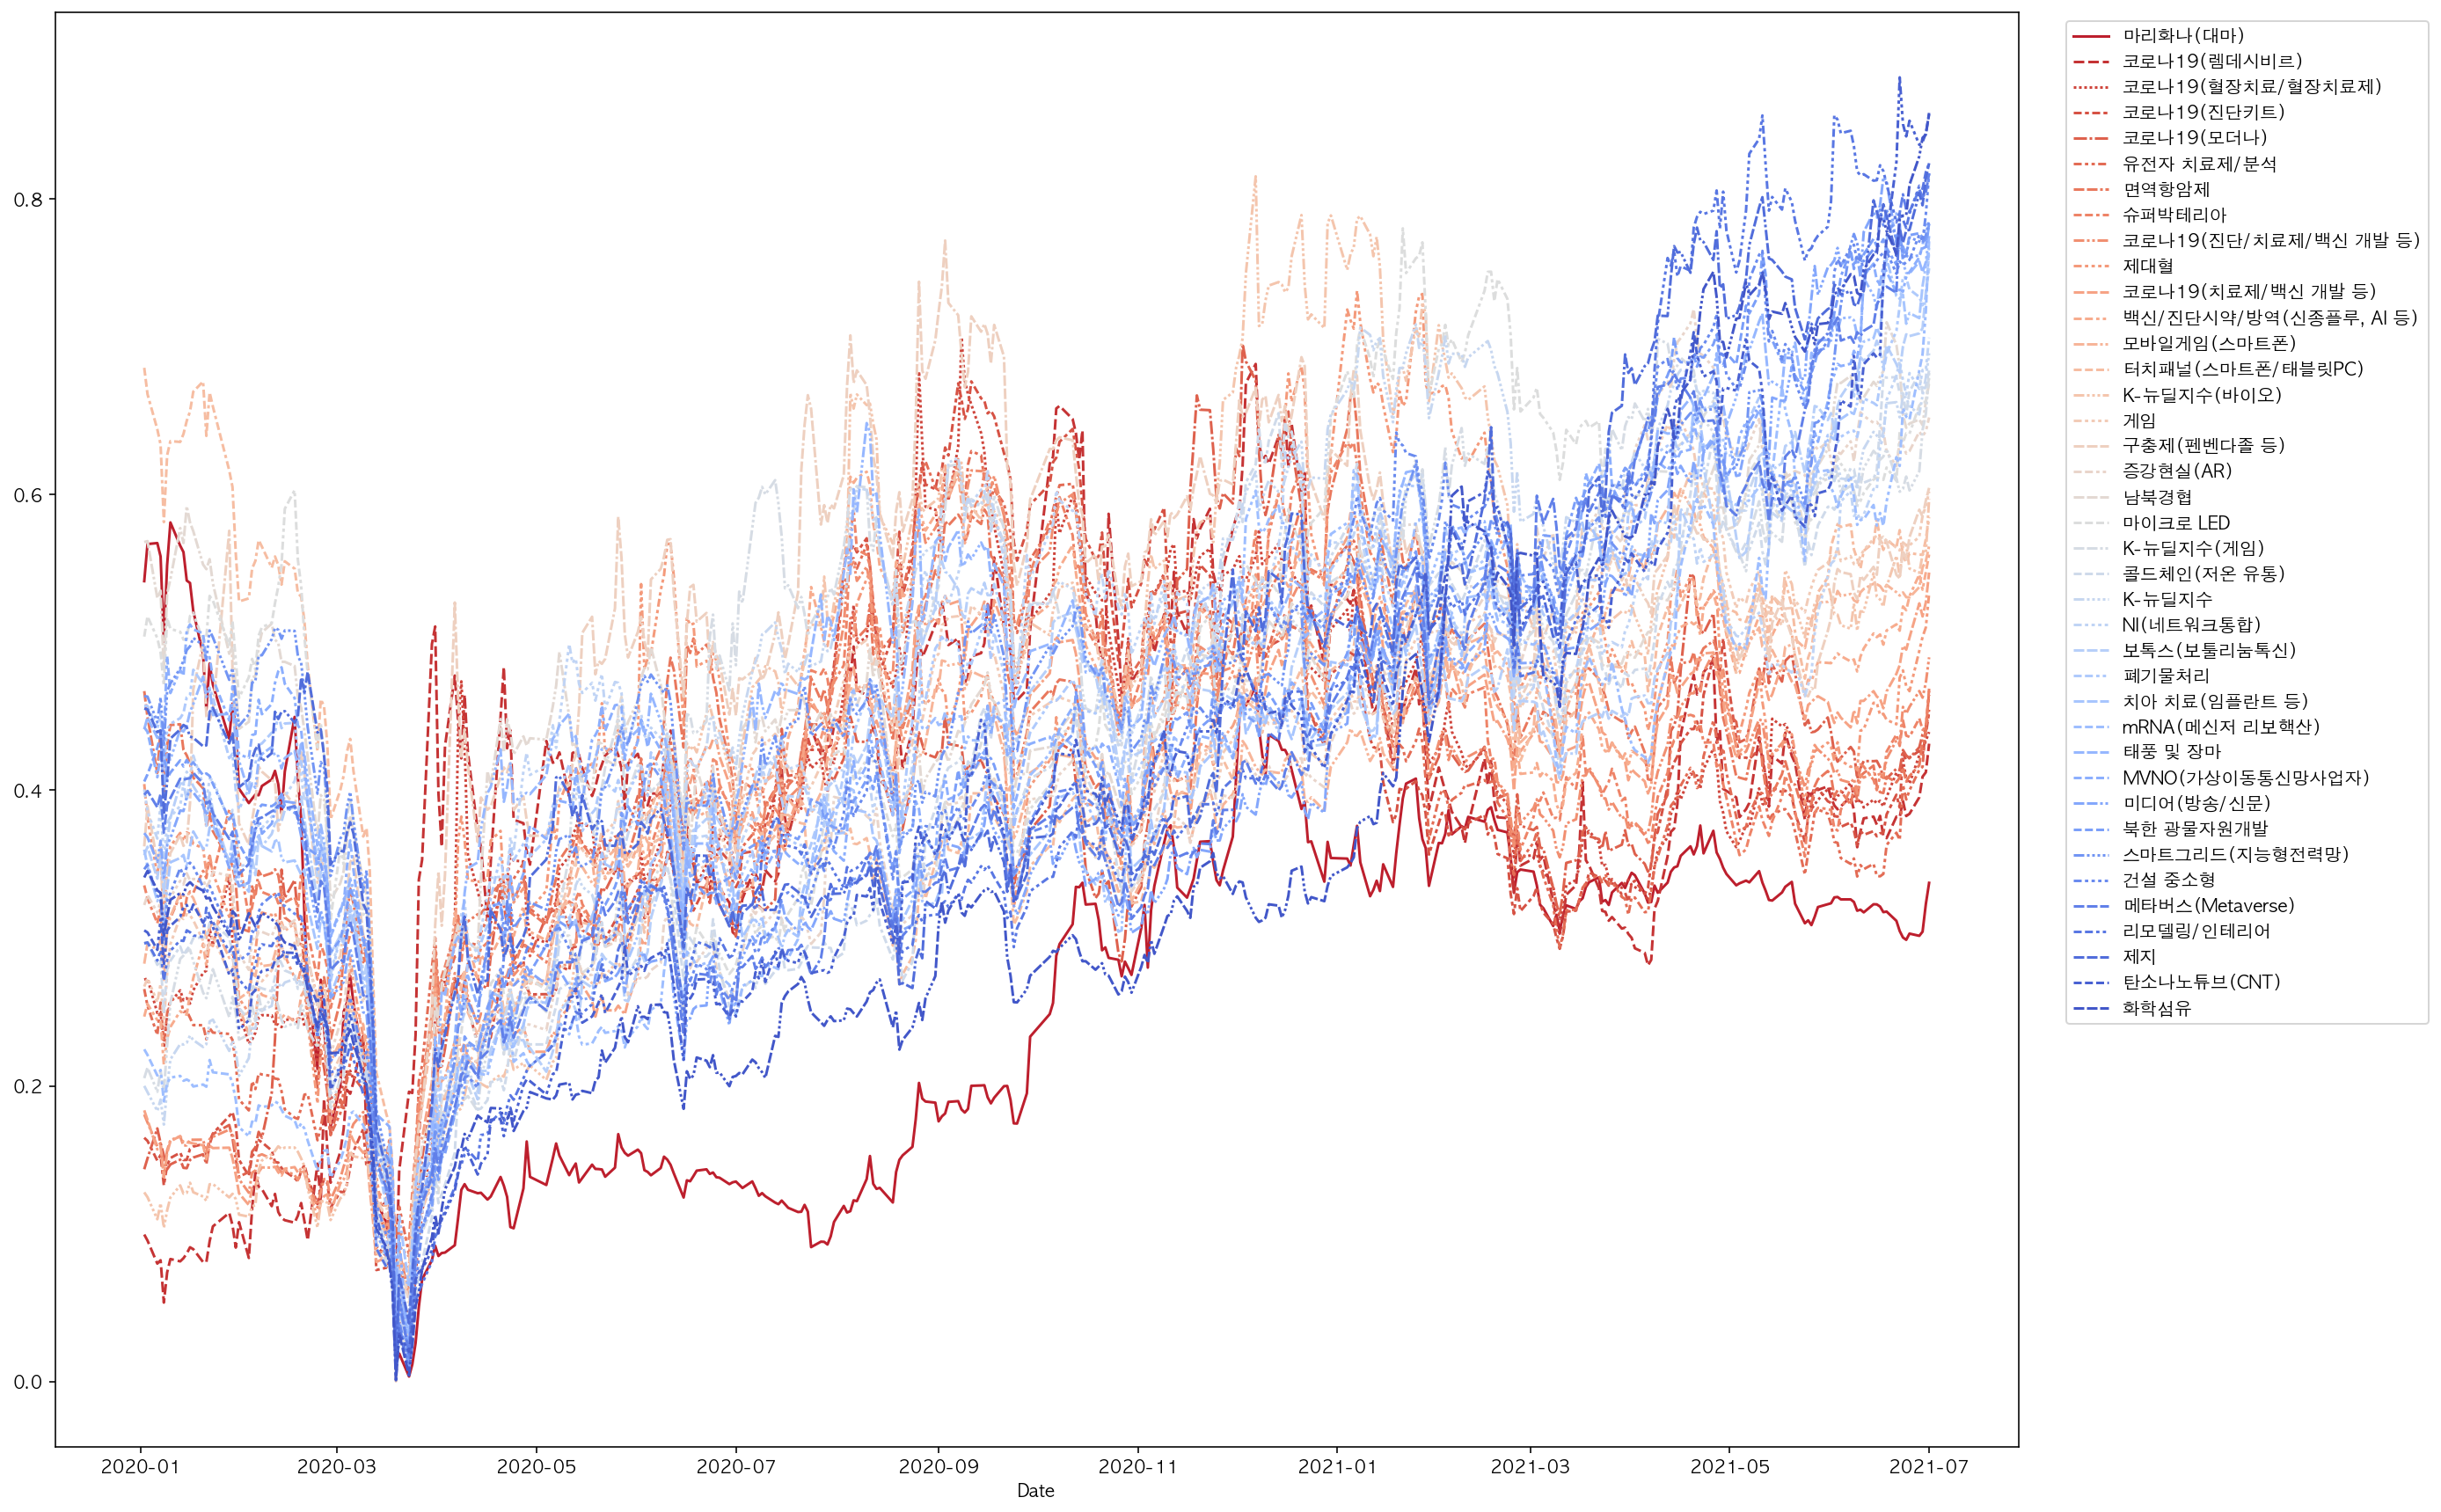

In [418]:
# 플롯 사이즈 조정
plt.figure(figsize = (20,15))
# 라인플롯으로 테마별 등락 조회
sns.lineplot(data = result_sorted, palette='coolwarm_r')

# legend 밖으로 옮기기
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)


## Result
- 2020년 초에는 모든 테마주가 하락했음
- 파랑색으로 마킹된 테마주들은 지금까지 지속적으로 상승하는 중
    - 메타버스와 미디어 등 디지털 산업군
    - 제지, 화학섬유 등의 제조업이 천천히 회복하는 것으로 보임
- 적갈색으로 마킹된 테마주들은 주로 코로나 19 테마주들이 많음
    - 코로나가 터진 후 다른 테마주보다 빠르게 상승하고 코로나가 완화됨에 따라 약하게 하향하는 중으로 보임
    - 코로나 이슈가 가장 핫할 때 가격이 먼저 올랐던 것이 아닐까 추정
- 코로나 관련주는 코로나가 완화됨에 따라 계속 내려갈 것으로 보이니 피해서 투자하자